In [1]:
%matplotlib inline
import keras
import keras.backend as K
from keras.layers import Input, Convolution2D, BatchNormalization, Lambda, Conv2DTranspose, InputSpec, Activation, merge
from keras.engine.topology import Layer
from keras.models import Model
import numpy as np
import tensorflow as tf
from vgg16 import VGG16
import matplotlib.pyplot as plt
from PIL import Image
import bcolz

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
dpath = '/run/media/backman/yay/imagenet/'

In [3]:
arr_lr = bcolz.open(dpath+'trn_resized_72.bc')[:5000]
arr_hr = bcolz.open(dpath+'trn_resized_288.bc')[:5000]

In [4]:
shp = arr_hr.shape[1:]

(288, 288, 3)


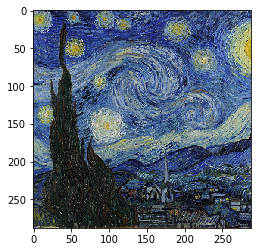

In [5]:
style = Image.open('/run/media/backman/yay/styleResults/style2.jpg')
style = style.resize(np.divide(style.size,3.5).astype('int32'))
style = np.array(style)[:shp[0], :shp[1], :shp[2]]
print(style.shape)
plt.imshow(style);

In [6]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

In [7]:
class CustomUpsampling(Layer):
    def __init__(self, **kwargs):
        self.input_spec = [InputSpec(ndim=4)]
        super(CustomUpsampling, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        height = 2 * s[1] if s[1] is not None else None
        width = 2 * s[2] if s[2] is not None else None
        return (s[0],
                height,
                width,
                   s[3])
    
    def call(self, inputs):
        height = 2 * int(inputs.shape[1])
        width = 2 * int(inputs.shape[2])
        return tf.image.resize_nearest_neighbor(
            inputs,
            [height, width]
        )

In [8]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

In [9]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1), 'valid')
    x = conv_block(x, nf, 3, (1,1), 'valid', act=False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

In [10]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [21]:
inp = Input(shp)
x = ReflectionPadding2D((40,40))(inp)
x = conv_block(x, 64, 9, (1,1))
x = conv_block(x, 64, 3)
x = conv_block(x, 64, 3)
for _ in range(5):
    x = res_block(x)
print(x)
x = up_block(x, 64, 3)
print(x)
x = up_block(x, 64, 3)
print(x)
x=Convolution2D(3, 9, 9,activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*127.5)(x)
print(x)


/usr/lib/python3.6/site-packages/keras/engine/topology.py:622: UserWarning: Class `__main__.ReflectionPadding2D` defines `get_output_shape_for` but does not override `compute_output_shape`. If this is a Keras 1 layer, please implement `compute_output_shape` to support Keras 2.
  output_shape = self.compute_output_shape(input_shape)
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (9, 9), strides=(1, 1), padding="same")`
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(2, 2), padding="same")`
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="valid")`
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use i

Tensor("merge_10/add:0", shape=(?, 72, 72, 64), dtype=float32)
Tensor("activation_19/Relu:0", shape=(?, 104, 104, 64), dtype=float32)
Tensor("activation_20/Relu:0", shape=(?, 208, 208, 64), dtype=float32)
Tensor("conv2d_32/Tanh:0", shape=(?, 208, 208, 3), dtype=float32)


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (8, 8), activation="tanh", padding="same")`
  del sys.path[0]


In [12]:
vgg_inp = Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable = False

/home/backman/mlSandbox/vgg16.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/home/backman/mlSandbox/vgg16.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/home/backman/mlSandbox/vgg16.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/home/backman/mlSandbox/vgg16.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding="same")`
  x = Convolution2

In [13]:
def get_outp(m, ln): 
    return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])


In [14]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style,0))]

In [15]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 144, 144, 128], dtype=int32),
 array([  1,  72,  72, 256], dtype=int32),
 array([  1,  36,  36, 512], dtype=int32),
 array([  1,  18,  18, 512], dtype=int32)]

In [16]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [17]:
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

In [18]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [19]:
w=[0.1, 0.2, 0.6, 0.1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [20]:
print(vgg1, vgg2)
loss = Lambda(tot_loss)(vgg1+vgg2)
m_style = Model([inp, vgg_inp], loss)
targ =  np.zeros((arr_hr.shape[0], 1))

[<tf.Tensor 'model_1/block2_conv2/Relu:0' shape=(?, 144, 144, 128) dtype=float32>, <tf.Tensor 'model_1/block3_conv2/Relu:0' shape=(?, 72, 72, 256) dtype=float32>, <tf.Tensor 'model_1/block4_conv2/Relu:0' shape=(?, 36, 36, 512) dtype=float32>, <tf.Tensor 'model_1/block5_conv2/Relu:0' shape=(?, 18, 18, 512) dtype=float32>] [<tf.Tensor 'model_1_1/block2_conv2/Relu:0' shape=(?, 104, 104, 128) dtype=float32>, <tf.Tensor 'model_1_1/block3_conv2/Relu:0' shape=(?, 52, 52, 256) dtype=float32>, <tf.Tensor 'model_1_1/block4_conv2/Relu:0' shape=(?, 26, 26, 512) dtype=float32>, <tf.Tensor 'model_1_1/block5_conv2/Relu:0' shape=(?, 13, 13, 512) dtype=float32>]


ValueError: Dimensions must be equal, but are 144 and 104 for 'lambda_8/sub_1' (op: 'Sub') with input shapes: [?,144,144,128], [?,104,104,128].

In [ ]:

m_style.compile('adam', 'mse')
m_style.fit([arr_lr, arr_hr], targ, 2, 2)

In [ ]:
top_model = Model(inp, outp)

In [ ]:
p = top_model.predict(arr_lr[10:11])

In [ ]:
plt.imshow(arr_lr[10].astype('uint8'));

In [ ]:
plt.imshow(p[0].astype('uint8'));